### Define utils function

In [ ]:
import pandas as pd
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os


def get_df():
    df = pd.read_json("/home/hutu/workspace/MMRetrieval/data/valid.json", lines=True)
    tmp = df.groupby("label_group").posting_id.agg("unique").to_dict()
    df["label"] = df.label_group.map(tmp)

    tmp = df.groupby("image_phash").posting_id.agg("unique").to_dict()
    df["phash"] = df.image_phash.map(tmp)

    return df


def visualize(df, index, col):
    """可视化图片和预测结果，预测结果为posting_id的list"""
    row = df.iloc[index]
    preds = row[col]
    img_dir: str = "/home/hutu/workspace/MMRetrieval/data/train_images"
    images = [df[df.posting_id == pred].image.values[0] for pred in preds]

    target_title = row.title
    target_img = row.image

    titles = [df[df.posting_id == pred].title.values[0] for pred in preds]
    images = [Image.open(os.path.join(img_dir, img)) for img in images]

    rows = 5
    cols = 5
    fig, ax = plt.subplots(rows, cols, figsize=(20, 20))

    plt.axis("off")

    for i in range(cols):
        ax[0, i].axis("off")

    for i in range(rows):
        ax[i, 0].axis("off")

    ax[0, 0].imshow(Image.open(os.path.join(img_dir, target_img)))
    ax[0, 0].set_title(
        "\n".join([target_title[i : i + 10] for i in range(0, len(target_title), 10)]),
        fontsize=12,
    )

    for i in range(1, rows):
        for j in range(1, cols):
            idx = (i - 1) * cols + (j - 1)
            ax[i, j].axis("off")
            if idx < len(images):
                ax[i, j].imshow(images[idx])
                ax[i, j].set_title(
                    "\n".join(
                        [
                            titles[idx][k : k + 10]
                            for k in range(0, len(titles[idx]), 10)
                        ]
                    ),
                    fontsize=12,
                )


def compute_f1(col):
    def f1(row):
        n = len(np.intersect1d(row["label"], row[col]))
        return 2 * n / (len(row["label"]) + len(row[col]))

    return f1


def compute_recall(col):
    def recall(row):
        n = len(np.intersect1d(row["label"], row[col]))
        return n / len(row["label"])

    return recall


def compute_precision(col):
    def precision(row):
        n = len(np.intersect1d(row["label"], row[col]))
        return n / len(row[col])

    return precision


def compute_precision_K(col, K):
    def precision(row):
        n = len(np.intersect1d(row["label"], row[col][:K]))
        return n / K

    return precision


def compute_AP(col, N):
    """compute average precision"""

    def AP(row):
        n = len(np.intersect1d(row["label"], row[col]))
        max_n = min(len(row[col]), N)
        if n == 0:
            return 0
        return (
            sum(
                [
                    compute_precision_K(col, i)(row)
                    for i in range(1, max_n + 1)
                    if row[col][i - 1] in row["label"]
                ]
            )
            / max_n
        )

    return AP

def combine(cols):
    def combine_(row):
        return np.unique(np.concatenate([row[col] for col in cols]))

    return combine_


df = get_df()
df.head(1)

,posting_id,image,image_phash,title,label_group,label,phash
0,train_1802986387,00144a49c56599d45354a1c28104c039.jpg,f815c9bb833ab4c8,Jubah anak size 1-12 thn,1835033137,"[train_1802986387, train_1396161074, train_713...",[train_1802986387]


### Image phase

In [2]:
df["f1"] = df.apply(compute_f1("phash"), axis=1)
df["recall"] = df.apply(compute_recall("phash"), axis=1)
df["precision"] = df.apply(compute_precision("phash"), axis=1)
df["AP"] = df.apply(compute_AP("phash", 50), axis=1)

print(df.f1.mean(), df.recall.mean(), df.precision.mean(), df.AP.mean())

0.5533137298280653 0.4197699950374416 0.9987437448964636 0.9984231505880969


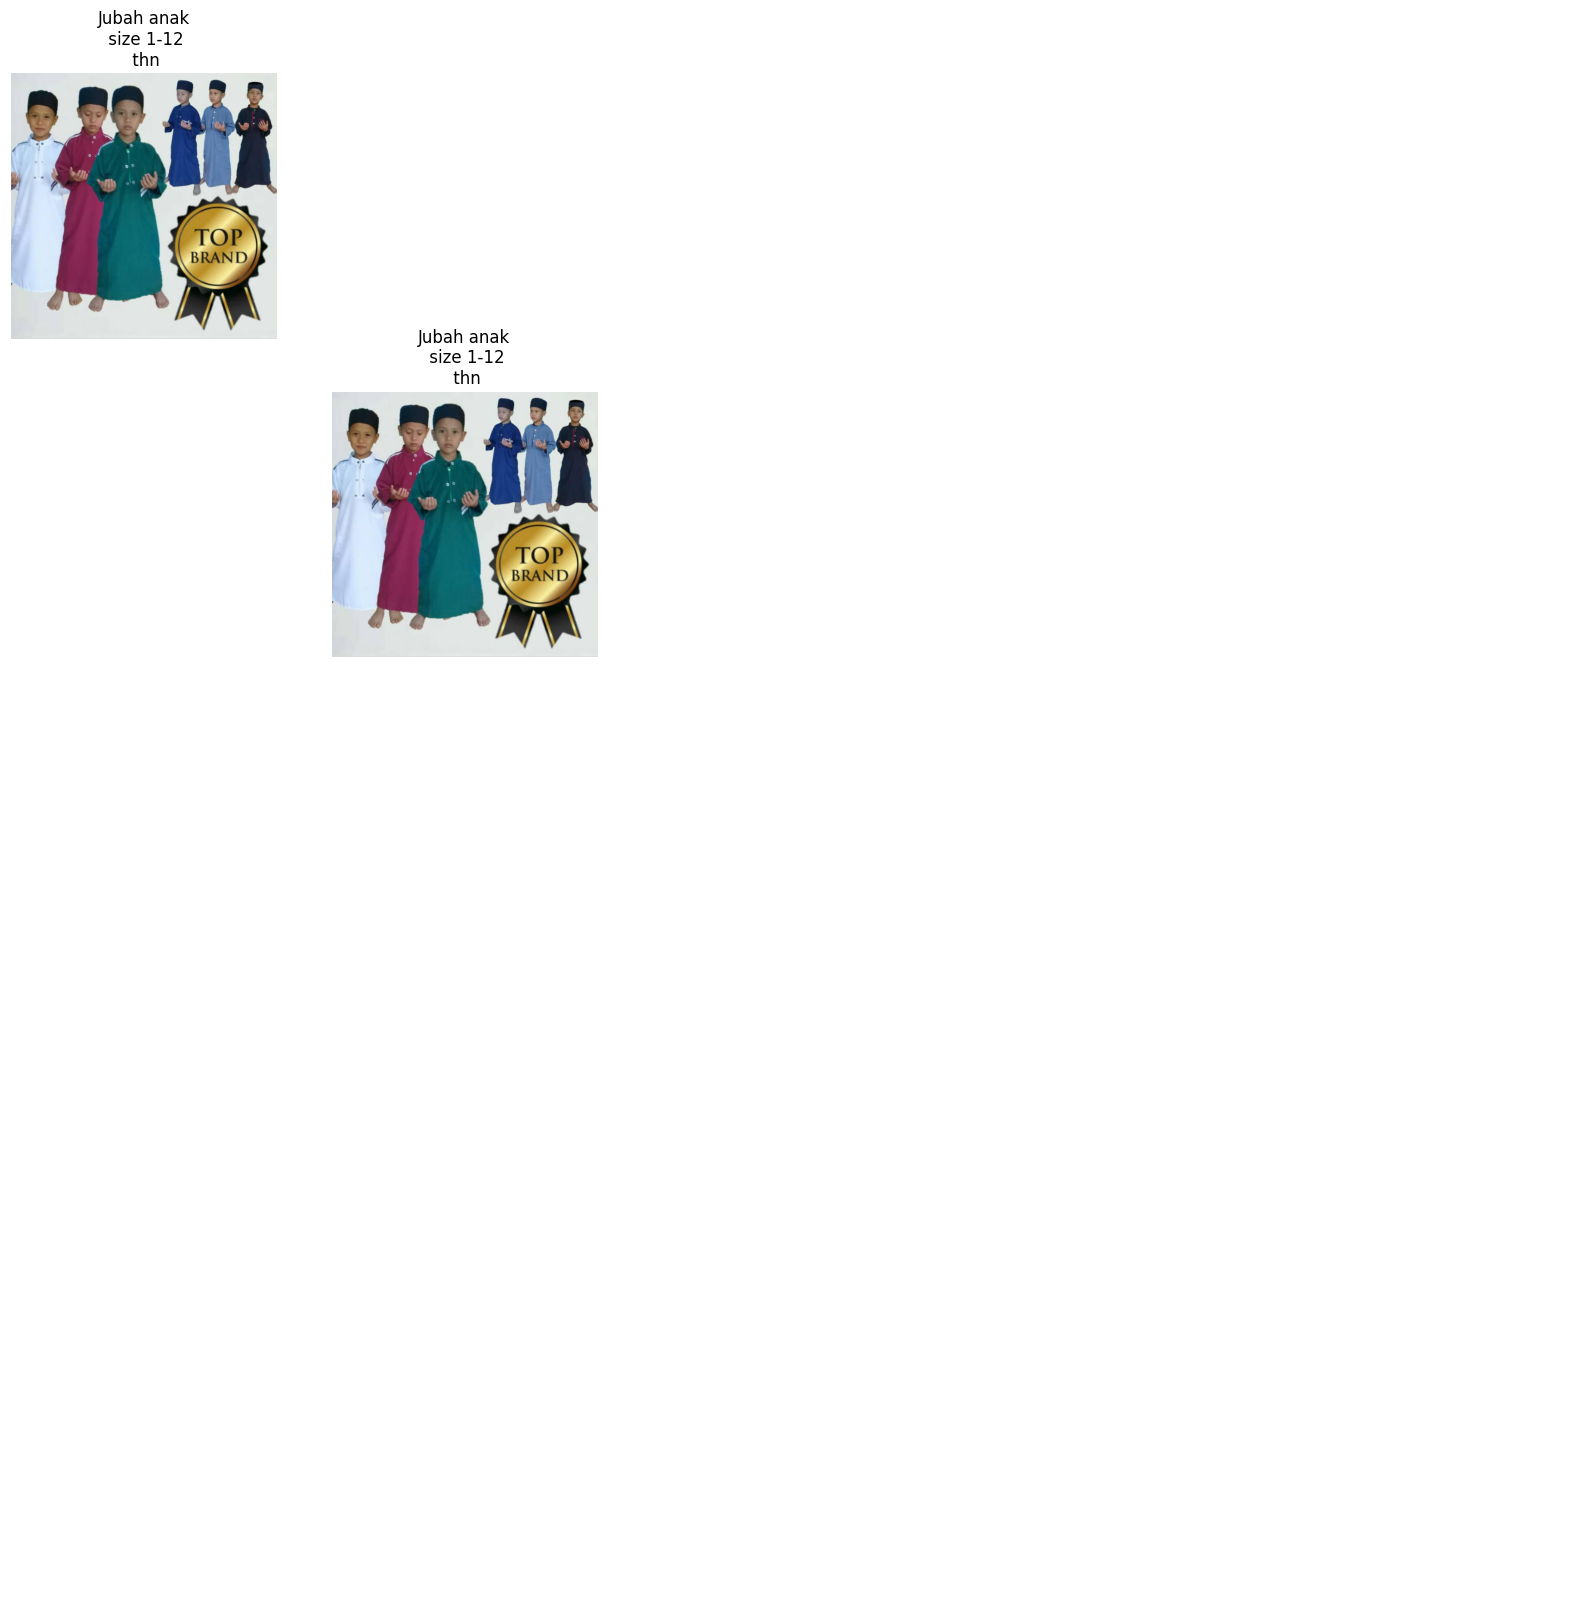

In [3]:
visualize(df, 0, "phash")

### CLIP with linear probe

In [4]:
from train.dataset import ShopeeDataset
from train.modeling_clip import CLIPForFusion, CLIPForEmbedding
from transformers import CLIPProcessor
from torch.utils.data import DataLoader
from dataclasses import dataclass
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "1"


@dataclass
class DataArguments:
    data_dir: str = "/home/hutu/workspace/MMRetrieval/data/valid.json"
    img_dir: str = "/home/hutu/workspace/MMRetrieval/data/train_images"


def get_collate_fn(processor):
    def collate_fn(batch):
        texts = [item["title"] for item in batch]
        images = [item["image"] for item in batch]
        text_encoded = processor(
            text=texts,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=77,
        )
        img_encoded = processor(images=images, return_tensors="pt", do_rescale=False)

        return {"text": text_encoded, "image": img_encoded}

    return collate_fn

In [5]:
data_args = DataArguments()
model_path = "/home/hutu/workspace/MMRetrieval/modeloutput/1211/infoNCE/checkpoint-700"

processor = CLIPProcessor.from_pretrained(model_path)
# model = CLIPForEmbedding.from_pretrained(
#     "/home/hutu/workspace/model/CLIP-ViT-L-14-laion2B-s32B-b82K"
# )

model = CLIPForFusion.from_pretrained(
    model_path
)

dataset = ShopeeDataset(data_args, split="valid")
loader = DataLoader(
    dataset,
    batch_size=256,
    num_workers=16,
    collate_fn=get_collate_fn(processor),
    shuffle=False,
)

In [6]:
from tqdm import tqdm

embs = []
# get image + text embedding into numpy array

model.eval()
model.cuda()
for batch in tqdm(loader):
    with torch.no_grad():
        with torch.amp.autocast("cuda", dtype=torch.float16):
            for k, v in batch.items():
                batch[k] = {key: val.cuda() for key, val in v.items()}
            emb = model(batch)
            # text_emb, image_emb = emb["text"], emb["image"]
            # emb = torch.cat([text_emb, image_emb], dim=-1)
        embs.append(emb.cpu().detach().numpy())

print(len(embs))

100%|██████████| 27/27 [00:40<00:00,  1.52s/it]

27


In [7]:
del model, processor
torch.cuda.empty_cache()
embs = np.concatenate(embs, axis=0)
# normalize
embs /= np.linalg.norm(embs, axis=1, keepdims=True)

In [8]:
embs.shape

(6823, 512)

Experients F1:
- threshold 0.75 for unfine-tuned CLIP, f1 score is 0.7988
- threshold 0.62 for fine-tuned CLIP(1080 steps bs 256), f1 score is 0.7977

In [9]:
import numpy as np
import torch
from tqdm import tqdm
import concurrent.futures

embs_pt = torch.tensor(embs).cuda()

# compute similarity
sim = embs_pt @ embs_pt.T
print(sim.shape)

# threshold
def process_threshold(threshold, sim, df, posting_id):
    mask = sim > threshold

    # get indices and sort them by similarity
    indices = [
        torch.nonzero(mask[i]).squeeze().cpu().numpy() for i in range(mask.shape[0])
    ]
    # convert element in indices to 1d array
    indices = [np.unique(i) for i in indices]
    sorted_indices = [
        indices[i][np.argsort(-sim[i, indices[i]].cpu().numpy())]
        for i in range(len(indices))
    ]

    # convert indices to posting_id
    topk_posting_id = [[posting_id[j] for j in row] for row in sorted_indices]

    df["clip"] = topk_posting_id

    f1 = df.apply(compute_f1("clip"), axis=1).mean()

    return f1, threshold


best_f1 = 0
best_threshold = 0
posting_id = df.posting_id.to_list()

with concurrent.futures.ThreadPoolExecutor() as executor:
    futures = [
        executor.submit(process_threshold, threshold, sim, df.copy(), posting_id)
        for threshold in np.linspace(0.4, 0.9, 200)
    ]
    for future in tqdm(concurrent.futures.as_completed(futures), total=len(futures)):
        f1, threshold = future.result()
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold
            print(best_f1, best_threshold)
            
print(best_f1, best_threshold)

torch.Size([6823, 6823])


  0%|          | 1/200 [02:21<7:50:33, 141.88s/it]

0.554276624995576 0.47788944723618093


 16%|█▋        | 33/200 [05:07<1:38:16, 35.31s/it]

0.5639891191002577 0.4804020100502513


 17%|█▋        | 34/200 [05:19<1:18:42, 28.45s/it]

0.5725382786371344 0.4829145728643216


 18%|█▊        | 35/200 [05:23<58:27, 21.26s/it]  

0.605001791476484 0.49296482412060305


 18%|█▊        | 37/200 [05:25<29:41, 10.93s/it]

0.6280331634924782 0.5005025125628141


 20%|█▉        | 39/200 [05:28<15:56,  5.94s/it]

0.648443238139651 0.5080402010050251


 22%|██▎       | 45/200 [05:31<03:19,  1.29s/it]

0.6632585223052931 0.5130653266331658


 23%|██▎       | 46/200 [05:32<03:26,  1.34s/it]

0.6693160518588598 0.5155778894472363


 24%|██▍       | 48/200 [05:38<05:52,  2.32s/it]

0.6758252013550142 0.5180904522613066


 24%|██▍       | 49/200 [05:40<05:27,  2.17s/it]

0.6927139291762163 0.5256281407035176


 26%|██▌       | 52/200 [05:43<03:53,  1.58s/it]

0.7048369744778056 0.5306532663316583


 26%|██▋       | 53/200 [05:45<03:38,  1.49s/it]

0.7091527898869145 0.5331658291457286


 28%|██▊       | 55/200 [05:49<03:56,  1.63s/it]

0.7306266418125027 0.5457286432160804


 30%|██▉       | 59/200 [05:51<01:56,  1.21it/s]

0.7345169495221168 0.5482412060301508


 31%|███       | 62/200 [05:52<01:10,  1.96it/s]

0.7380755531952717 0.5507537688442211
0.7407220772575446 0.5532663316582915


 32%|███▏      | 63/200 [05:53<01:24,  1.62it/s]

0.7440155842524834 0.5557788944723618


 32%|███▏      | 64/200 [05:53<01:18,  1.72it/s]

0.7477029810968325 0.5582914572864321


 32%|███▎      | 65/200 [07:36<1:07:47, 30.13s/it]

0.7520842721198507 0.5608040201005026


 33%|███▎      | 66/200 [07:46<54:12, 24.28s/it]  

0.7547676439571727 0.5633165829145729


 34%|███▎      | 67/200 [07:57<45:13, 20.40s/it]

0.7736366154429287 0.578391959798995


 34%|███▍      | 68/200 [07:58<32:02, 14.56s/it]

0.7863784417993841 0.5959798994974874


 40%|████      | 80/200 [08:10<03:20,  1.67s/it]

0.7908142687198028 0.6035175879396986


 41%|████      | 82/200 [08:15<03:38,  1.85s/it]

0.7953770463512503 0.6135678391959799


 42%|████▎     | 85/200 [08:21<03:46,  1.97s/it]

0.7965425450742155 0.6185929648241206


 43%|████▎     | 86/200 [08:24<04:01,  2.12s/it]

0.7975496454397129 0.6236180904522614


 46%|████▋     | 93/200 [08:29<01:20,  1.32it/s]

0.7976196130777781 0.6286432160804021


100%|██████████| 200/200 [15:54<00:00,  4.77s/it]

0.7976196130777781 0.6286432160804021


In [10]:
# get topk
# K = 5

# topk = torch.topk(sim, K, dim=1).indices

# print(topk.shape)

# # get topk posting_id
# posting_id = df.posting_id
# posting_id = posting_id.to_list()

# topk_posting_id = [[posting_id[i] for i in row] for row in topk]

# df["clip"] = topk_posting_id

In [11]:
# evaluate
df["f1_clip"] = df.apply(compute_f1("clip"), axis=1)
df["recall_clip"] = df.apply(compute_recall("clip"), axis=1)
df["precision_clip"] = df.apply(compute_precision("clip"), axis=1)
df["AP_clip"] = df.apply(compute_AP("clip", 50), axis=1)

print(
    df.f1_clip.mean(),
    df.recall_clip.mean(),
    df.precision_clip.mean(),
    df.AP_clip.mean(),
)

KeyError: 'clip'

<Axes: >

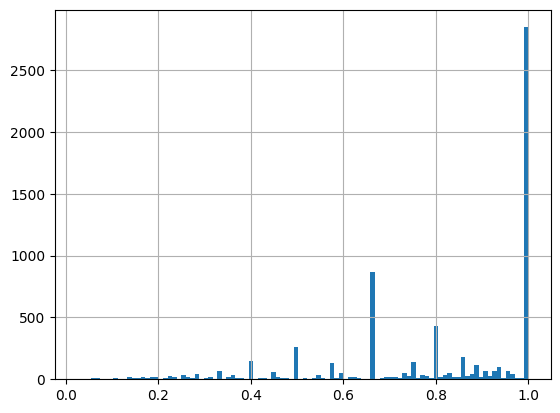

In [ ]:
df.f1_clip.value_counts().sort_index()
# 绘制直方图
df.f1_clip.hist(bins=100)

In [ ]:
index = 14

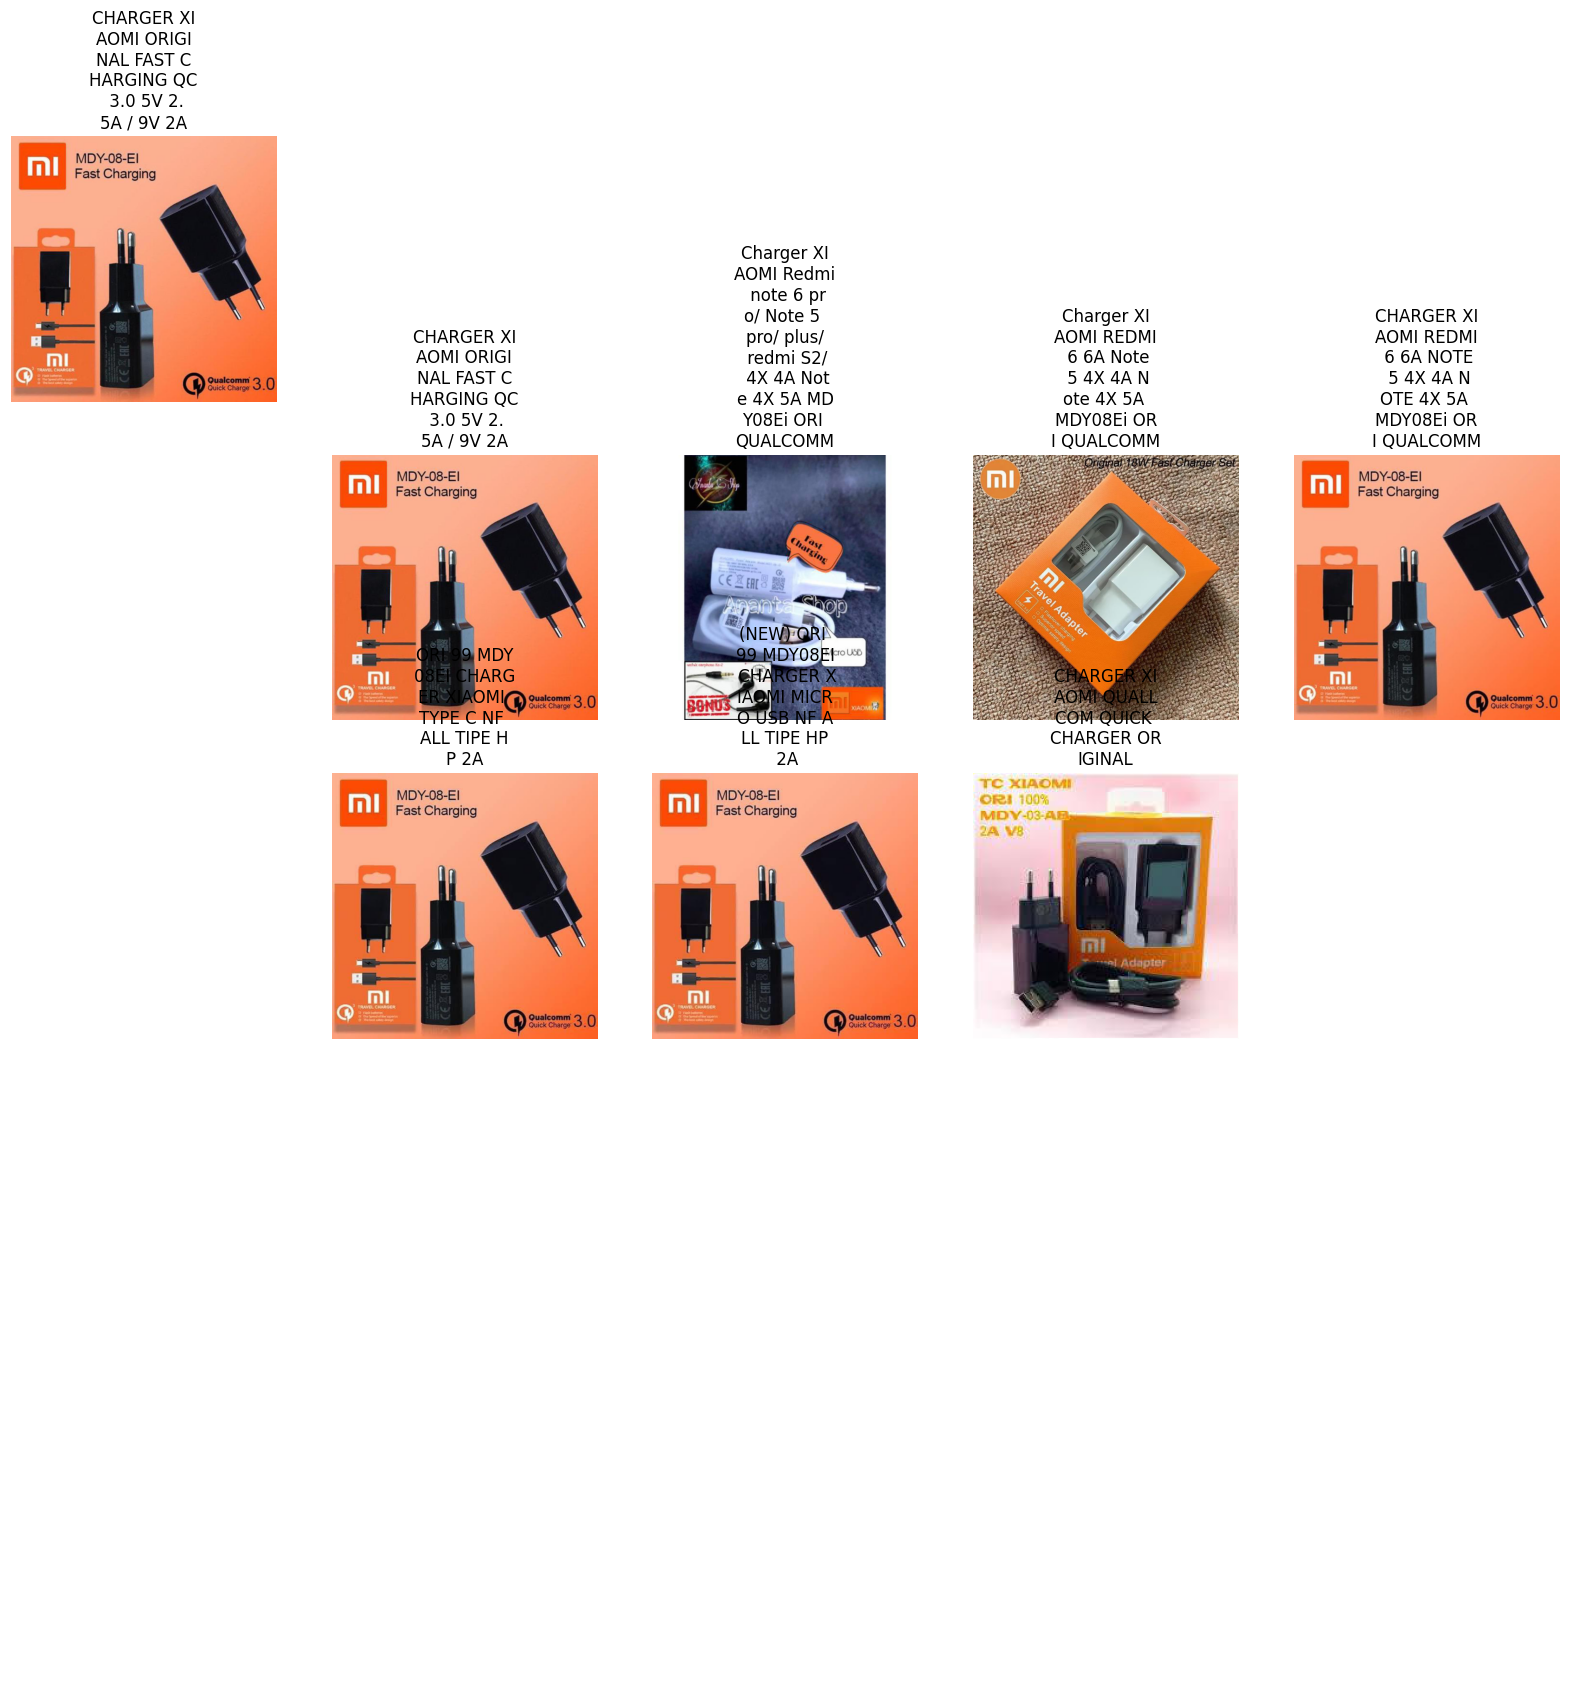

In [ ]:
visualize(df, index, "label")

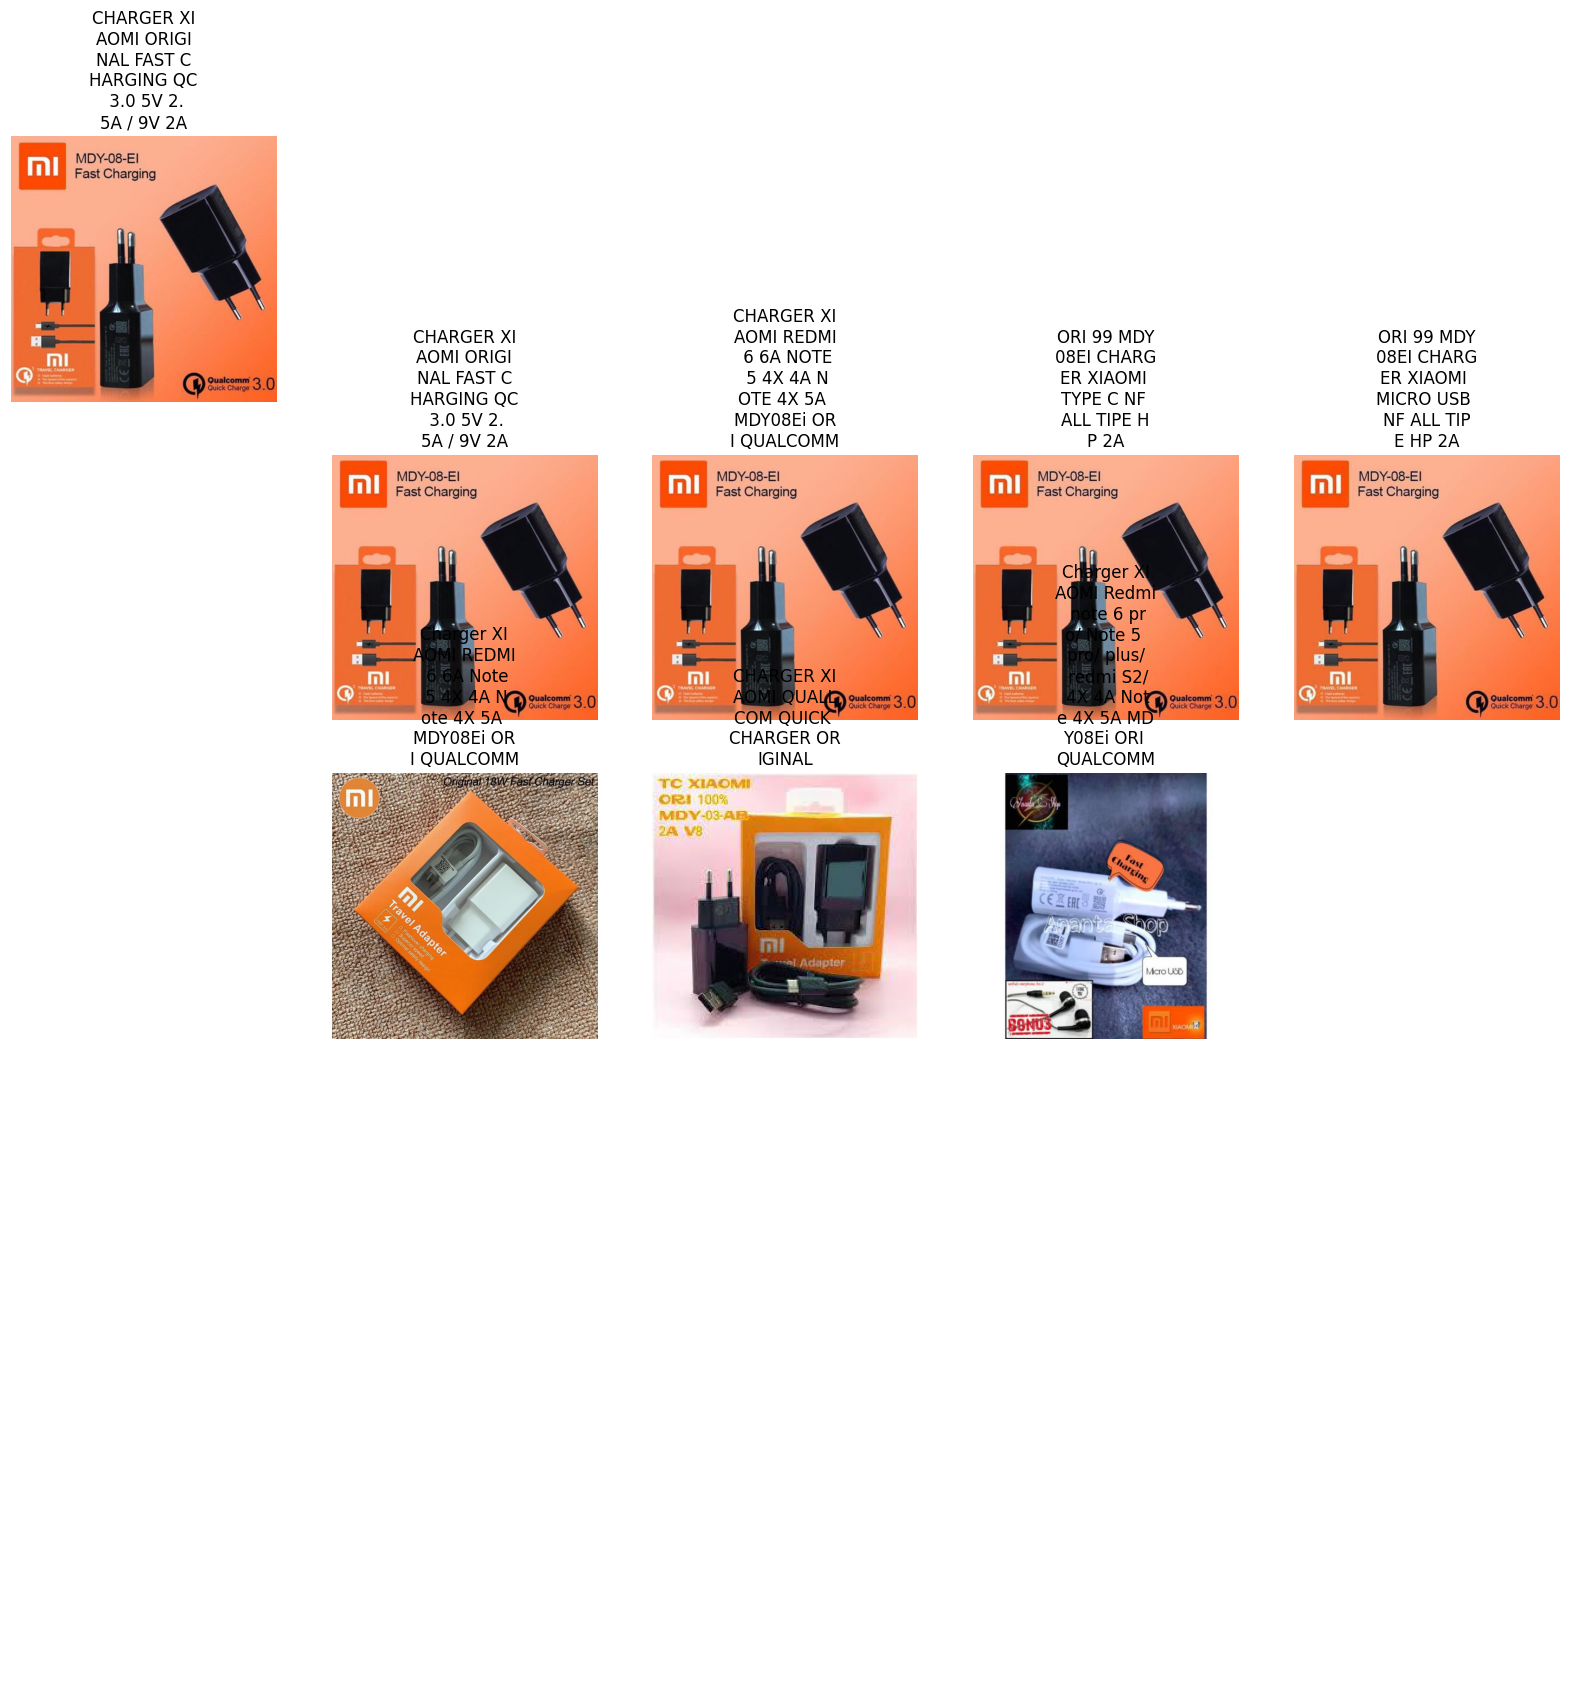

In [ ]:
visualize(df, index, "clip")

In [ ]:
(
    df["f1_clip"][index],
    df["recall_clip"][index],
    df["precision_clip"][index],
    df["AP_clip"][index],
    len(df["clip"][index]),
)

(1.0, 1.0, 1.0, 1.0, 8)